In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTEN
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import pickle

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Reading Data

In [2]:
data=pd.read_csv("C:/Users/LENOVO/Downloads/Job titles and industries.csv")

In [3]:
data

,job title,industry
0,technical support and helpdesk supervisor - co...,IT
1,senior technical support engineer,IT
2,head of it services,IT
3,js front end engineer,IT
4,network and telephony controller,IT
...,...,...
8581,data entry clerk,Marketing
8582,content creator,Marketing
8583,sales & marketing manager,Marketing
8584,marketing & digital marketing consultant,Marketing


# EDA

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8586 entries, 0 to 8585
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job title  8586 non-null   object
 1   industry   8586 non-null   object
dtypes: object(2)
memory usage: 134.3+ KB


no missing values in data

In [5]:
data['industry'].unique()

array(['IT', 'Marketing', 'Education', 'Accountancy'], dtype=object)

our data has 4 classes

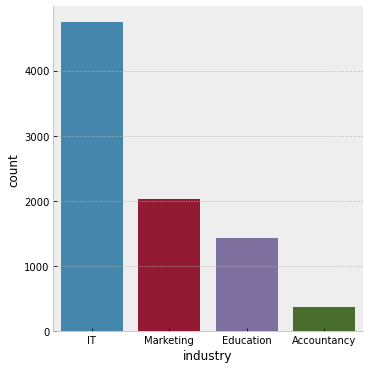

In [6]:
# distribution of classes
sns.catplot(x='industry',kind='count',data=data)

In [7]:
data['industry'].value_counts()

IT             4746
Marketing      2031
Education      1435
Accountancy     374
Name: industry, dtype: int64

we have 4 imbalanced classes

In [8]:
data['job title'].unique()

array(['technical support and helpdesk supervisor - county buildings, ayr soa04086',
       'senior technical support engineer', 'head of it services', ...,
       'sales & marketing manager',
       'marketing & digital marketing consultant',
       'creative copywriter (arabic/english)'], dtype=object)

In [9]:
data['job title'].value_counts()

marketing executive                                           91
php developer                                                 54
trainee network technician                                    53
software developer                                            53
marketing manager                                             49
                                                              ..
digital designer - ux/ui                                       1
digital marketing executive - restaurant chain                 1
marketing and creative manager - salary circa £50k - poole     1
data analyst, sql, ecommerce, central london - £45k            1
creative copywriter (arabic/english)                           1
Name: job title, Length: 3890, dtype: int64

job title column has punctutation that should be cleaned

# Feature Engineering

In [10]:
data['job titles']=data['job title'].str.replace('[^A-Za-z1-9]',' ')

In [11]:
data['job titles'].unique()

array(['technical support and helpdesk supervisor   county buildings  ayr soa 4 86',
       'senior technical support engineer', 'head of it services', ...,
       'sales   marketing manager',
       'marketing   digital marketing consultant',
       'creative copywriter  arabic english '], dtype=object)

checking if the is upper case letters need to be converted to lower case

In [12]:
data['job titles'].str.isupper().sum()

0

tokenizing job title columns to split its sentences into words using word tokenize from nltk package

In [13]:
data.drop('job title',axis=1,inplace=True)
t=data['job titles'].tolist()
data['job title']=t
data.drop('job titles',axis=1,inplace=True)

In [14]:
data['job title']= data['job title'].apply(lambda x: nltk.word_tokenize(x))

In [15]:
data.head()

,industry,job title
0,IT,"[technical, support, and, helpdesk, supervisor..."
1,IT,"[senior, technical, support, engineer]"
2,IT,"[head, of, it, services]"
3,IT,"[js, front, end, engineer]"
4,IT,"[network, and, telephony, controller]"


removing stop words from job title column

In [16]:
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output
data['job title']= data['job title'].apply(lambda x:remove_stopwords(x))

In [17]:
data.head()

,industry,job title
0,IT,"[technical, support, helpdesk, supervisor, cou..."
1,IT,"[senior, technical, support, engineer]"
2,IT,"[head, services]"
3,IT,"[js, front, end, engineer]"
4,IT,"[network, telephony, controller]"


we could observe that words like (of, it) were removed from the third row as it is not usefull and maybe meaningless for the model

stemming words using lemmatizer of nltk package to get back every word to its origin and deal with different variations of words as the same word

In [18]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text
data['job title']=data['job title'].apply(lambda x:lemmatizer(x))
data['job title']=[" ".join(title) for title in data['job title'].values]
data.head()

,industry,job title
0,IT,technical support helpdesk supervisor county b...
1,IT,senior technical support engineer
2,IT,head service
3,IT,j front end engineer
4,IT,network telephony controller


split data into train-test and using stratified method to keep balance among splits

In [19]:
X_train , X_test , Y_train , Y_test = train_test_split(data['job title'] , data['industry'],test_size=0.2 ,stratify=data['industry'], random_state= 0)

Balancing our train data using SMOTEN package

In [20]:
#print rows in data before resampling
print(X_train.shape)
print(Y_train.value_counts())
#balancing data step
oversample = SMOTEN({'Accountancy':800,'Education':2000,'Marketing':2500})
titles=np.array(X_train).reshape(-1,1)
train, Y = oversample.fit_resample(titles, Y_train)
train=train.flatten()
# print rows in data after resampling
print(train.shape)
print(Y.shape)
data=pd.DataFrame({'job title':train,'industry':Y})
X_train=data['job title']
Y_train=data['industry']
#print value counts of classes
print(Y_train.value_counts())

(6868,)
IT             3796
Marketing      1625
Education      1148
Accountancy     299
Name: industry, dtype: int64
(9096,)
(9096,)
IT             3796
Marketing      2500
Education      2000
Accountancy     800
Name: industry, dtype: int64


# Creating Model using pipeline

first transform our text data to tf-idf matrix to be able to use it with our classifier

In [21]:
#using ngram of range 1 to 3 to be able to get meaningfull words combination
pipe = Pipeline([('vectorizer', TfidfVectorizer(ngram_range=(1,3))), ('linearsvc', LinearSVC(C=4))])
#using cross validate score to be certain about results
scores = cross_val_score(pipe, X_train, Y_train, cv=5)
scores.mean()

0.9432741694808764

In [22]:
#train data then predict test data nd calculate accuracy
pipe.fit(X_train,Y_train)
print(pipe.score(X_test,Y_test))
Y_predict=pipe.predict(X_test)


0.9481955762514552


In [23]:
#printing precision, recall and f1-score for every prediction and total accuracy
print(classification_report(Y_test , Y_predict ,target_names=data['industry'].unique()))

              precision    recall  f1-score   support

          IT       0.96      0.91      0.93        75
   Education       0.94      0.90      0.92       287
   Marketing       0.97      0.97      0.97       950
 Accountancy       0.90      0.93      0.92       406

    accuracy                           0.95      1718
   macro avg       0.94      0.93      0.94      1718
weighted avg       0.95      0.95      0.95      1718



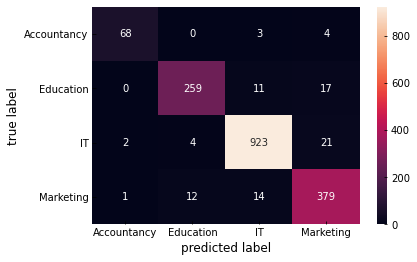

In [24]:
#confusion matrix
m=pd.crosstab(Y_predict,Y_test,dropna=False)
sns.heatmap(m.T,annot=True,fmt='d')
plt.xlabel('predicted label')
plt.ylabel('true label');

# Save model as pickle file

In [25]:
pickle.dump(pipe, open('linearsvcmodel.pkl', 'wb'))